# novoSpaRc Analysis: Domain Prediction

## Xenium Breast Cancer, InSitu Replicate 1

https://www.10xgenomics.com/products/xenium-in-situ/human-breast-dataset-explorer


### 1. Import packages

In [2]:
# imports
import novosparc as ns
import math
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import altair as alt
from scipy.spatial.distance import cdist, squareform, pdist
from scipy.stats import ks_2samp
from scipy.stats import pearsonr
from scanpy import read_10x_h5
from matplotlib.pyplot import figure

import random
random.seed(0)

In [3]:
import cv2 as cv
from skimage import io, color
import torch
from torch.nn import functional as F
import json
import sys
sys.path.append('/Users/ameliaschroeder/CeLEry/CeLEry_package')

import CeLEry as cel

### 2. Load data


In [6]:
# cells to be filtered out based on total UMI and number of genes expressed
os.chdir("")
lowUMI_cellID = pd.read_csv("cell_ID_toRemove_filtered_25_25.csv",sep=",",na_filter=False,index_col=0)

In [7]:
#Read in gene expression and spatial location
os.chdir("")
adata = read_10x_h5("Xenium_FFPE_Human_Breast_Cancer_Rep1_cell_feature_matrix.h5")
spatial_full = pd.read_csv("Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv",sep=",",na_filter=False,index_col=0)

In [8]:
os.chdir("") #scheme 2

train_index = pd.read_csv("trainCell_index.csv",sep=",")
test_index = pd.read_csv("testCell_index.csv",sep=",")

train_index = list(train_index.iloc[:,1])
test_index = list(test_index.iloc[:,1])

In [9]:
os.chdir("")
kmeans10_clustering = pd.read_csv("clusters.csv", index_col=0)
kmeans10_clustering

,Cluster
Barcode,
1,5
2,8
3,4
4,1
5,4
...,...
167778,2
167779,2
167780,2


In [12]:
spatial_full

,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,total_counts,cell_area,nucleus_area
cell_id,,,,,,,,
1,377.663005,843.541888,154,0,0,154,110.361875,45.562656
2,382.078658,858.944818,64,0,0,64,87.919219,24.248906
3,319.839529,869.196542,57,0,0,57,52.561875,23.526406
4,259.304707,851.797949,120,0,0,120,75.230312,35.176719
5,370.576291,865.193024,120,0,0,120,180.218594,34.499375
...,...,...,...,...,...,...,...,...
167778,7455.404785,5115.021094,238,1,0,239,219.956094,61.412500
167779,7483.771045,5111.720703,80,0,0,80,38.427969,25.964844
167780,7470.119580,5119.350366,406,0,0,406,287.690469,86.158125


In [13]:
# The pixel size of Xenium 0.2125 microns. 
# Coordinates in microns from cells.csv.gz can be converted to pixel coordinates 
# by dividing by the pixel size. The origin of the coordinate system is the upper left of the TIFF image.


pixel_size = 0.2125

spatial = pd.DataFrame()
spatial['0'] = spatial_full.x_centroid
spatial['1'] = [1] * 167782
spatial['2'] = spatial_full.x_centroid
spatial['3'] = spatial_full.y_centroid 
spatial['4'] = spatial_full.x_centroid / pixel_size
spatial['5'] = spatial_full.y_centroid / pixel_size

b = ['CellID '] * 167782
a = list(range(1,167783))

#spatial.index = [m+str(n) for m,n in zip(b,a)]

spatial.index = spatial.index.astype('str')


spatial = spatial.drop(['0'], axis = 1)
spatial.index.name = '0'
spatial.columns = spatial.columns.astype('int64')
spatial = spatial.astype('int64')

adata.obs_names = spatial.index.astype('str')

In [20]:
TrainDatafull = cel.make_annData_spatial(adata.copy(), spatial, filtered = True)
TrainDatafull.var['genename'] = TrainDatafull.var.gene_ids
TrainDatafull

AnnData object with n_obs × n_vars = 166313 × 313
    obs: 'select', 'x_cord', 'y_cord', 'x_pixel', 'y_pixel', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'
    uns: 'log1p'

### 3. Filter out cells with low UMI and low number of genes expressed


In [23]:
os.chdir(r"/Users/ameliaschroeder/Box/Biostatistician_Mingyao/Celery/Data_Celery/Xenium_BreastCancer/Xenium_BreastCancer/InSituReplicate1")
TrainDatafull.obs_names = TrainDatafull.obs_names.astype(np.int64) 

TrainDatafull_filtered = TrainDatafull.copy()[~TrainDatafull.obs_names.isin(lowUMI_cellID.x), :]
TrainDatafull_filtered


/Users/ameliaschroeder/miniconda3/envs/novosparc/lib/python3.8/site-packages/anndata-0.8.0-py3.8.egg/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [1, 2, 3, 4, 5]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/Users/ameliaschroeder/miniconda3/envs/novosparc/lib/python3.8/site-packages/anndata-0.8.0-py3.8.egg/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


View of AnnData object with n_obs × n_vars = 121277 × 313
    obs: 'select', 'x_cord', 'y_cord', 'x_pixel', 'y_pixel', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'
    uns: 'log1p'

In [25]:
cel.get_zscore(TrainDatafull_filtered)

/Users/ameliaschroeder/miniconda3/envs/novosparc/lib/python3.8/site-packages/scipy-1.10.0-py3.8-macosx-10.9-x86_64.egg/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


### 4. Split data into train and test data 

In [27]:
### Spliting into training and testing data for prediction/evalutaiton:

# making sure to use same sets across all methods

train_index = np.array(train_index).astype('str')
test_index = np.array(test_index).astype('str')

# 90% train
DataSubtrain90_coor = TrainDatafull_filtered[train_index,]

# 10% holdoff

DataSubtest10_coor = TrainDatafull_filtered[test_index,]


In [28]:
DataSubtrain90_coor

View of AnnData object with n_obs × n_vars = 60638 × 313
    obs: 'select', 'x_cord', 'y_cord', 'x_pixel', 'y_pixel', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'
    uns: 'log1p'

In [29]:
DataSubtest10_coor

View of AnnData object with n_obs × n_vars = 60639 × 313
    obs: 'select', 'x_cord', 'y_cord', 'x_pixel', 'y_pixel', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'
    uns: 'log1p'

In [30]:
holdoff = 10
dataSection1 = DataSubtrain90_coor 
dataSection2 = DataSubtest10_coor

In [31]:
dataSection1.obs['x'] = dataSection1.obs['x_cord']
dataSection1.obs['y'] = dataSection1.obs['y_cord']

dataSection2.obs['x'] = dataSection2.obs['x_cord']
dataSection2.obs['y'] = dataSection2.obs['y_cord']

<ipython-input-31-86617e75a1a2>:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  dataSection1.obs['x'] = dataSection1.obs['x_cord']
<ipython-input-31-86617e75a1a2>:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  dataSection2.obs['x'] = dataSection2.obs['x_cord']


In [32]:
dataSection1.X = dataSection1.X.toarray()
dataSection2.X = dataSection2.X.toarray()

In [33]:
dataSection1

AnnData object with n_obs × n_vars = 60638 × 313
    obs: 'select', 'x_cord', 'y_cord', 'x_pixel', 'y_pixel', 'n_counts', 'x', 'y'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'
    uns: 'log1p'

In [34]:
dataSection2

AnnData object with n_obs × n_vars = 60639 × 313
    obs: 'select', 'x_cord', 'y_cord', 'x_pixel', 'y_pixel', 'n_counts', 'x', 'y'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'
    uns: 'log1p'

In [35]:
# remove extra data stored 

del adata
del TrainDatafull_filtered
del TrainDatafull


In [49]:
import random

random.seed(2021)
torch.manual_seed(2021)
np.random.seed(2021)

#subset to only 40,000 cells so that novoSpaRc method can run properly
ind = random.sample(range(0,60638), 20000)
ind2 = random.sample(range(0,60639), 20000)

print(len(ind))
print(len(ind2))

datatrain = dataSection1[ind]
datatest = dataSection2[ind2]
genes = dataSection1.var.index

20000
20000


## Running novosparc

In [38]:
random.seed(2021)
torch.manual_seed(2021)
np.random.seed(2021)

## Running novosparc
locations_apriori = datatrain.obs[['x', 'y']].values
tissue = ns.cm.Tissue(dataset=datatest, locations=locations_apriori)
num_neighbors_s = num_neighbors_t = 10

In [ ]:
# params for linear cost
atlas_genes = datatrain.var
markers = list(set(genes))
num_genes = len(markers)
print(num_genes)
atlas_matrix = datatrain.to_df().values
markers_idx = pd.DataFrame({'markers_idx': np.arange(num_genes)}, index=markers)
markers_to_use = np.concatenate(markers_idx.loc[markers].values)

tissue.setup_reconstruction(atlas_matrix=atlas_matrix, 
                        markers_to_use=markers_to_use, 
                        num_neighbors_s=num_neighbors_s, 
                        num_neighbors_t=num_neighbors_t)

tissue.reconstruct(alpha_linear=0.8, epsilon=5e-2)

location_pred = tissue.gw


313
Setting up for reconstruction ... done ( 3480.41 seconds )
Reconstructing spatial information with 313 markers: 60639 cells and 60638 locations ... 
Trying with epsilon: 5.00e-03


In [ ]:
location_pred.shape

## Domain Prediction

In [66]:
datatrain_clust = datatrain.copy()
datatest_clust = datatest.copy()

In [67]:
barcodes = (kmeans10_clustering.index-1).astype(str)
datatrain_clust2 = datatrain_clust.copy()[datatrain_clust.obs_names.isin(list(barcodes)), :]
datatrain_clust2.obs['clusters'] = kmeans10_clustering['Cluster'][datatrain_clust2.obs_names.astype('int64')].values.astype('str')

datatrain_clust2


<ipython-input-67-797b55194e0d>:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  datatrain_clust2.obs['clusters'] = kmeans10_clustering['Cluster'][datatrain_clust2.obs_names.astype('int64')].values.astype('str')


AnnData object with n_obs × n_vars = 19995 × 313
    obs: 'select', 'x_cord', 'y_cord', 'x_pixel', 'y_pixel', 'n_counts', 'x', 'y', 'clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'
    uns: 'log1p'

In [68]:
barcodes = (kmeans10_clustering.index-1).astype(str)
datatest_clust2 = datatest_clust.copy()[datatest_clust.obs_names.isin(list(barcodes)), :]
datatest_clust2.obs['clusters'] = kmeans10_clustering['Cluster'][datatest_clust2.obs_names.astype('int64')].values.astype(str)

datatest_clust2



<ipython-input-68-27ea4124ac3b>:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  datatest_clust2.obs['clusters'] = kmeans10_clustering['Cluster'][datatest_clust2.obs_names.astype('int64')].values.astype(str)


AnnData object with n_obs × n_vars = 19998 × 313
    obs: 'select', 'x_cord', 'y_cord', 'x_pixel', 'y_pixel', 'n_counts', 'x', 'y', 'x_pred', 'y_pred', 'clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'
    uns: 'log1p'

In [69]:
location_pred_dom = location_pred.copy()
location_pred_dom = location_pred_dom[:,datatrain_clust.obs_names.isin(list(barcodes))]

location_pred_dom.shape


(20000, 19995)

In [70]:
## cell type prediction
type_pred = []
for i in range(location_pred.shape[0]):
    bestindex = np.argmax(location_pred_dom[i,:])
    
    # best.append(bestindex)
    type_pred.append(datatrain_clust2.obs['clusters'][bestindex])

In [71]:
type_pred = np.array(type_pred)
type_pred_final = type_pred[datatest_clust.obs_names.isin(list(barcodes))]
np.sum(type_pred_final == datatest_clust2.obs['clusters'])/len(type_pred_final)

0.8630863086308631

In [72]:
datatest_clust2.obs['pred_layer'] = type_pred_final

In [73]:
order = ['1', '2', '3', '5', '4', '6', '7', '8', '9', '10']

## Truth

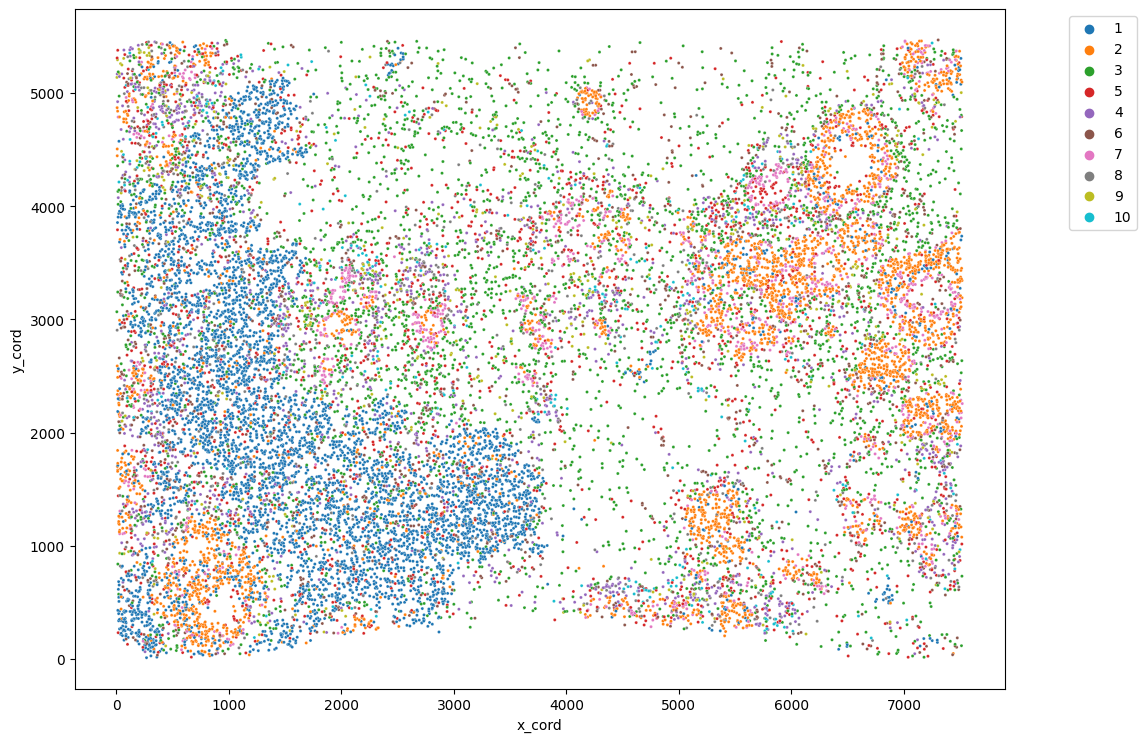

In [79]:
figure(figsize=(12, 9), dpi=100)

sns.scatterplot(data=datatest_clust2.obs, x='x_cord', y='y_cord', hue='pred_layer',  hue_order=order, s=5)
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))


os.chdir("/Users/ameliaschroeder/Box/Amelia_Biostatistician/Celery/Output_Celery/Xenium_BreastCancer/Figures_Final/Domain")

plt.savefig('xenium_rep1_scheme2_domains_pred_novosparc_subsample40000_size5.png')
#plt.savefig('xenium_rep1_domains_pred_novosparc.pdf')




## Predicted

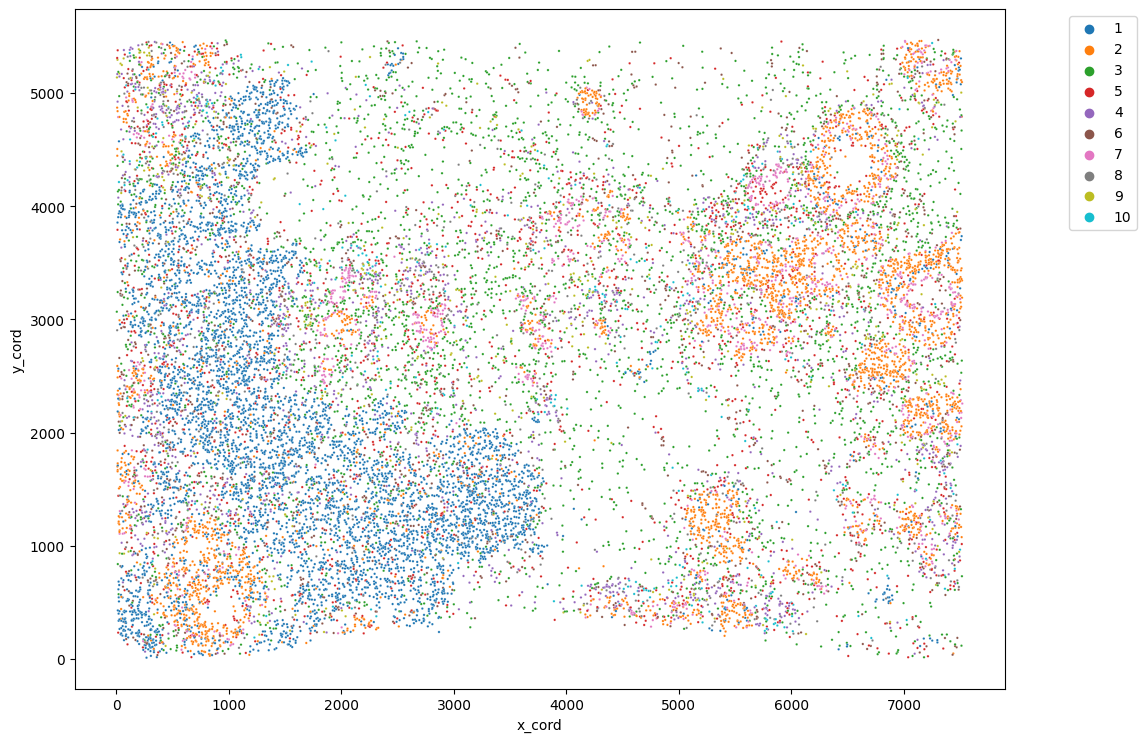

In [80]:
figure(figsize=(12, 9), dpi=100)

sns.scatterplot(data=datatest_clust2.obs, x='x_cord', y='y_cord', hue='pred_layer',  hue_order=order, s=3)
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))


os.chdir("/Users/ameliaschroeder/Box/Amelia_Biostatistician/Celery/Output_Celery/Xenium_BreastCancer/Figures_Final/Domain")

plt.savefig('xenium_rep1_scheme2_domains_pred_novosparc_subsample40000_size3.png')
#plt.savefig('xenium_rep1_domains_pred_novosparc.pdf')




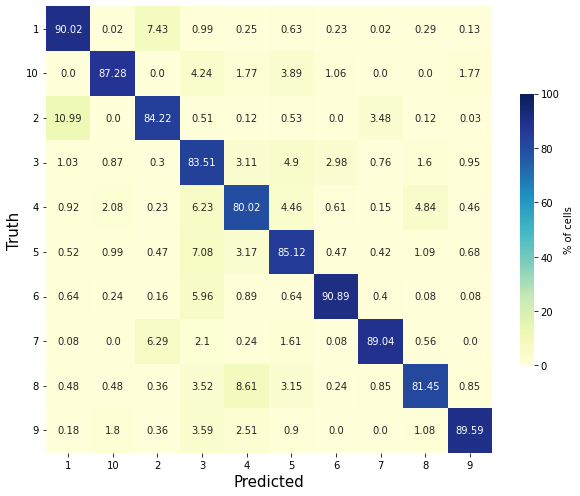

In [75]:
import seaborn as sns
contigency = pd.crosstab(datatest_clust2.obs['clusters'], type_pred_final)

for i in range(contigency.shape[0]):
    contigency.iloc[i,:] = contigency.iloc[i,:]/np.sum(contigency, axis=1)[i] * 100

fig = plt.figure(num=None, figsize=(10, 10), facecolor='w', edgecolor='k')

plt.clf()

ax = fig.add_subplot(111)

ax.set_aspect(1)

annot_m = np.empty(contigency.shape,dtype='<U16')
for i in range(contigency.shape[0]):
    for j in range(contigency.shape[0]):
        annot_m[i,j] = np.round(contigency.iloc[i,j], 2)

res = sns.heatmap(contigency, annot=annot_m, fmt="", cmap="YlGnBu", vmin=0.0, vmax=100, cbar_kws={'label': '% of cells', "shrink": 0.5}).set(ylabel="Truth", xlabel="Predicted")
cbar_axes = ax.figure.axes[-1]
ax.figure.axes[-1].yaxis.label.set_size(10)
# cbar = res.collections[0].colorbar
# cbar.set_label('Label for colour bar axis', labelpad=40)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Truth", fontsize=15)
# plt.title('How to plot a coningency table with python \n using matplotlib and seaborn ?',fontsize=12)

plt.xticks([i+0.5 for i in range(contigency.shape[0])], list(contigency.index))
plt.xticks(rotation=0)

plt.yticks([i+0.5 for i in range(contigency.shape[1])], list(contigency.index))
plt.yticks(rotation=0)

plt.yticks(rotation=0)

os.chdir("/Users/ameliaschroeder/Box/Amelia_Biostatistician/Celery/Output_Celery/Xenium_BreastCancer/Figures_Final/Domain")
plt.savefig('xenium_rep1_scheme2_novosparc_domain_contigency_subsample40000.png', dpi=100)


plt.show()

